In [1]:
# import...
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import math

os.chdir(  "/Users/etmu9498/research/code/scripts-winter2023/")
import helper_fns_winter2023
sys.path.append(  "/Users/etmu9498/research/code/scripts-winter2023/cloud-top-height-stats")
import eyewall_metadata
import find_cloud_tops
import cloud_top_plotting

In [2]:
fl_root_path = "/Users/etmu9498/research/data/in-situ-noaa-processed/"
os.chdir(fl_root_path + "/2021")
data = xr.open_dataset("20210927H1_sam_processed.nc")
data

<xarray.Dataset>
Dimensions:         (time: 33766)
Coordinates:
  * time            (time) float64 18.15 18.15 18.15 18.15 ... 27.52 27.52 27.52
Data variables: (12/19)
    HT.d            (time) float32 ...
    THETA.d         (time) float32 ...
    THETAV.d        (time) float32 ...
    WS.d            (time) float32 ...
    WD.d            (time) float32 ...
    UWZ.d           (time) float32 ...
    ...              ...
    PSURF.d         (time) float32 ...
    LATref          (time) float32 ...
    LONref          (time) float32 ...
    rmw             (time) float64 ...
    center_dist     (time) float64 ...
    rel_vort        (time) float64 ...
Attributes:
    Author:       Created by NOAA HRD. Link to data: https://www.aoml.noaa.go...
    Editor:       Edited by: Ethan Murray (etmu9498@colorado.edu)
    Attribution:  This Dataset is based off the dataset 20210927H1_sam.nc. Pl...
    Note:         These data have been limited to P-3 heights between 2.5 km ...

In [3]:
# the script below returns a nice dataframe showing each tc date, pass, time, intensity, and w values!
# this dataframe can easily be used to make a w distribution vs intensity plot, and intensification, wind shear, quadrants,
# etc information can be added on later :)

# recursive loop code taken from "scripts-winter2023/cloud-top-height-stats/find_cloud_top_stats"
def get_w_dataframe(tc='all', eye_limits='default'):
    crl_root_path = "/Users/etmu9498/research/data/crl-all-data-processed/"
    fl_root_path = "/Users/etmu9498/research/data/in-situ-noaa-processed/"
    # use a helper fn to get the relevant years and files
    yearlist, filelist = helper_fns_winter2023.get_crl_datasets( tc=tc)

    # print out the number of files to be used
    filecount = 0
    for yeari in range( len( filelist)):
        # count all the names in this year, and add to the count
        filecount += len( filelist[ yeari])
    print("Number of data files to be used in analysis: " + str( filecount))

    # load eyewall limits from helper function
    metadata = eyewall_metadata.all_metadata( eye_limits=eye_limits)
    
    
    # make a pandas dataframe to hold w information for each pass
    # year   |   date   |   pass   |   peaks  |
    # -----------------------------------------
    #  ...   |    ...   |   ....   |    ...   |
    df_peaks = pd.DataFrame( )
    # save values in temporary lists here: will be added to df_peaks once filled
    df_yearlist = []
    df_datelist = []
    df_passlist = []
    df_intensity = []
    df_category = []
    df_w = []

    # do this for all the datasets! years and filenames
    for yeari, yearval in enumerate( yearlist):
        print( "Year: " + yearval)
        
        # flight level files for this year
        fl_file_list_current_year = helper_fns_winter2023.load_flight_level(fl_root_path + yearval, print_files=False)
        
        for filei, fileval in enumerate( filelist[ yeari]):
            # load crl data
            # os.chdir( crl_root_path + yearval)
            # crl_data = xr.open_dataset( fileval)
            # print( "CRL File: " + fileval)

            # find the corresponding fl file
            for fli, flval in enumerate(fl_file_list_current_year):
                if flval[0:10] == fileval[3:13]:
                    fl_name = flval
                    break
            os.chdir( fl_root_path + yearval)
            fl_data = xr.open_dataset( fl_name)
            # print( "FL File: " + fileval)
                    
            
            # grab the limits for this case
            date = fileval[7:11]
            # check if this date exists... if not, give it some empty eyewall limits!
            # also account for fred am and pm cases!!
            if date == '0812':
                if fileval[11:13] == "H1":
                    eyewall_limits = metadata[ yearval]['eyewall_limits'][ '0812am']
                elif fileval[11:13] == "H2":
                    eyewall_limits = metadata[ yearval]['eyewall_limits'][ '0812pm']
            elif date in metadata[ yearval]['eyewall_limits'].keys():
                eyewall_limits = metadata[ yearval]['eyewall_limits'][ date]
            else:
                eyewall_limits = [ ()]
                
                
            # make sure intensity metadata are inputed for this year!
            if len( metadata[yearval]['intensity'].keys() ) > 0:
                if date == '0812':
                    if fileval[11:13] == "H1":
                        intensity = metadata[ yearval]['intensity'][ '0812am']
                    elif fileval[11:13] == "H2":
                        intensity = metadata[ yearval]['intensity'][ '0812pm']
                elif date in metadata[ yearval]['intensity'].keys():
                    intensity = metadata[yearval]['intensity'][date]
                else:
                    print( metadata[ yearval]['intensity'].keys())
                    intensity = 0
            else:
                intensity = 0
                
               
            # do this for each of the eyewall limit pairs! Can have multiple eyes per crl dataset
            for eyei, eyeval in enumerate( eyewall_limits):

                # do all of the appending in this if statement- eliminate cases without valid eyewalls!
                if len( eyeval) > 0:
                    # find the corresponding FLIGHT LEVEL!! indices to the time limits
                    ind0 = np.argmin( np.abs(fl_data.time.values - eyeval[0] ))
                    ind1 = np.argmin( np.abs(fl_data.time.values - eyeval[1] ))
                                                        
                    # *** # 
                    # add the metadata and w values found to the dataframe!
                    df_yearlist.append( yearval)
                    df_datelist.append( date)
                    df_passlist.append( eyei)
                    df_w.append( fl_data['UWZ.d'].values[ind0:ind1])
                    if date == '0812':
                        if fileval[11:13] == "H1":
                            df_intensity.append( metadata[yearval]['intensity']['0812am'])
                            df_category.append( metadata[yearval]['category']['0812am'])
                        elif fileval[11:13] == "H2":
                            df_intensity.append( metadata[yearval]['intensity']['0812pm'])
                            df_category.append( metadata[yearval]['category']['0812pm'])
                    else:
                        df_intensity.append( metadata[yearval]['intensity'][date])
                        df_category.append( metadata[yearval]['category'][date])
                    
    # finally, assemble and return the distribution peak dataframe!
    df_peaks['year'] = df_yearlist
    df_peaks['date'] = df_datelist
    df_peaks['pass'] = df_passlist
    df_peaks['intensity (kt)'] = df_intensity
    df_peaks['tc category'] = df_category
    df_peaks['w (m/s)'] = df_w
    return df_peaks


In [4]:
# given the w distribution dataframe created above, create a w distribution vs intensity plot!!
# code taken from "scripts\statistics\wh_covariances.py" and "code/tests/2023-01-13 flight level w calculations.ipynb"
def plot_w_dists(df_w, binwidth=.1, smoothwidth=10):
    # create w distributions for every TC intensity

    # put things in lists for easier looping
    # saving titles
    fig_title = [ 'tropical-depressions', 'tropical-storms', 'weak-hurricanes', 'strong-hurricanes']
    # nicely formatted titles
    fig_title_nice = [ 'Tropical Depressions', 'Tropical Storms', 'Weak Hurricanes', 'Strong Hurricanes']
    categories = ['td', 'ts', 'wh', 'sh']
    colors = ['b', 'k', 'y', 'g']
    
    # make the figure
    plt.figure( figsize=(14, 6))
    fs = 18
    helper_fns_winter2023.change_font_sizes(fs, fs)

    # make the plot look nice
    title = ( "Vertical Velocity Distribution for Each Intensity" )
    plt.suptitle( title)

    plt.subplot(121)
    plt.title("Linear Plot")
    # plt.ylabel("Probability of a Given W Value (Sums to 100%)")
    plt.ylabel("W Probability (%)")
    plt.xlabel("W (m/s)")
    # plt.grid('on')
    plt.ylim([-.5, 11])
    plt.xlim([-10, 10])
    plt.xticks([-10,-5,0,5,10])

    plt.subplot(122)
    plt.title("Log Plot")
    # plt.ylabel("Probability of a Given W Value (Sums to 100%)")
    # plt.xlabel("Flight Level Vertical Velocity Values (m/s)")
    # plt.grid('on')
    plt.ylabel("W Probability (%)")
    plt.xlabel("W (m/s)")
    plt.yscale('log')
    plt.ylim([.001, 11])
    plt.xlim([-10, 10])
    plt.xticks([-10,-5,0,5,10])
    
    # do this for every tc category
    for i in range( 4):

        print( 'case ' + categories[i])
        
        # find w for this category subset
        df_cat = df_w.loc[ np.where( df_w['tc category'] == categories[i])[0]]
        w = []
        for w_i in df_cat['w (m/s)']:
            w += w_i.tolist()
        
        # print(w[0:100])
        w = np.array(w)
        
        # initial variables
        wmin, wmax, wmean = np.nanmin( w), np.nanmax( w), np.nanmean( w)
        w_bin=np.arange( wmin - .5, wmax+.5, binwidth)
        meanw_count = []
        # binning and smoothing w
        # do this for every w bin
        for newi in w_bin:
            # find the points that fall within this height bin for this step
            res=np.where(np.logical_and( w >= newi - binwidth / 2., w <= newi + binwidth / 2. ))
            # append the count to the list!
            meanw_count.append( len( res[0]) / len( w))
        # smooth data before plotting to eliminate noise
        box_pts = smoothwidth
        box = np.ones(box_pts)/box_pts
        prob_smooth = np.convolve( meanw_count, box, mode='same')

        print('mean w: ' + str( wmean) + ' m/s')
        
        # inside loop: add average lines to plot
        plt.subplot(121)
        plt.plot( w_bin, prob_smooth * 100, linewidth=1.5, label=fig_title_nice[i], c=colors[i])
        if i == 3:
            plt.legend(loc='upper right', fontsize=round(fs*(2/3)))
        plt.subplot(122)
        plt.plot( w_bin, prob_smooth * 100, linewidth=1.5, label=fig_title_nice[i], c=colors[i])


    # save the final figure!
    os.chdir( "/Users/etmu9498/research-private/eye-cloud-paper")
    plt.savefig( 'intensity-pdfs.png', bbox_inches='tight', dpi=500, transparent=False )

Number of data files to be used in analysis: 35
Year: 2021
Year: 2022
case td
mean w: 0.1877202478420702 m/s
case ts
mean w: 0.030522066165544568 m/s
case wh
mean w: 0.03737772267610135 m/s
case sh
mean w: 0.04972472210813243 m/s


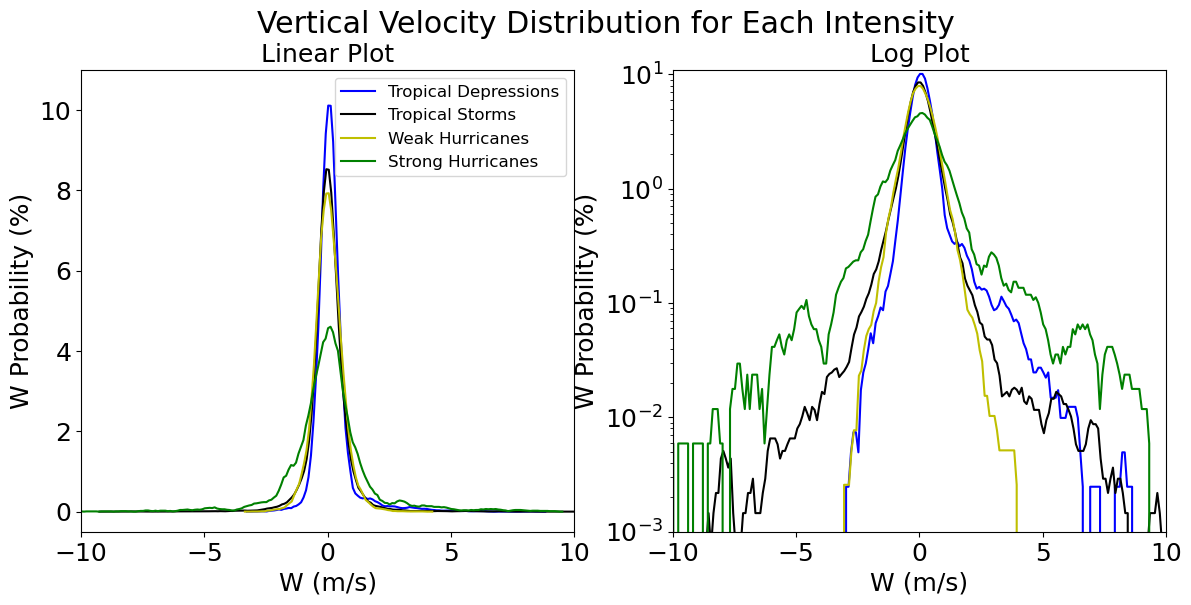

In [7]:
inputdict = {}
inputdict['2021'] = ['P3_20210926H1_processed.nc']

df_w = get_w_dataframe(tc='all')
plot_w_dists(df_w, binwidth=.1, smoothwidth=5) # 1

In [6]:
df_w

,year,date,pass,intensity (kt),tc category,w (m/s)
0,2021,0812,0,30.0,td,"[0.0041073416, 0.19714749, 0.29512876, 0.13818..."
1,2021,0812,1,30.0,td,"[-0.16574034, -0.08933159, -0.072231546, -0.07..."
2,2021,0812,2,30.0,td,"[0.7252568, 0.68505377, 0.6830011, 0.5848586, ..."
3,2021,0812,0,32.5,td,"[0.15800759, 0.21035066, 0.17980464, 0.1348747..."
4,2021,0812,1,32.5,td,"[0.24288417, 0.24833135, 0.21246915, 0.1149827..."
...,...,...,...,...,...,...
61,2022,0925,1,45.0,ts,"[0.74865216, 0.9525797, 0.6742887, 1.7136495, ..."
62,2022,0926,0,65.0,wh,"[-0.7538837, -0.38317043, -0.3143439, -0.26192..."
63,2022,0926,1,65.0,wh,"[0.6237257, 0.52305037, 0.5292107, 0.57636553,..."
64,2022,0926,2,65.0,wh,"[0.5065552, 0.38553417, 0.40255752, 0.23633987..."


In [7]:
# testing- print out some of the quantities!

# for wi, wval in enumerate( df_w['w (m/s)']):
#     print(df_w['date'][wi])
#     print(len(wval))

# print out a subset of weak hurricanes
# df_wh = df_w.loc[ np.where( df_w['tc category'] == 'wh')[0]]
# df_wh

# print( df_wh['w (m/s)'][12])
# print(np.nanmin( df_wh['w (m/s)'][12]))